Librerias

In [1]:
!pip install pycaret
!pip install sklearn-evaluation
import gdown
import subprocess
import os
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from datetime import datetime, timedelta
from scipy import signal,stats
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from scipy.signal import find_peaks
from pycaret.classification import *
from sklearn.impute import SimpleImputer
from pycaret.classification import pull,plot_model,evaluate_model, finalize_model, get_metrics,tune_model, ensemble_model, blend_models, predict_model,save_model, compare_models
from io import BytesIO
import base64
from sklearn.metrics import classification_report, confusion_matrix
from jinja2 import Template
from matplotlib import cm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 772.5 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 165.8/165.8 kB 2.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Using cached jedi-0.19.1-py2.py3-none-any.whl.metadata (22 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 486.1/486.1 kB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.8/106.8 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.8/21.8 MB 20.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.0/82.0 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.2/302.2 kB 14.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 54.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.7/80.7 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━

Carga de datos

In [2]:
def download_and_extract(file_url, zip_filename):
    print(f"Descargando {zip_filename}...")
    gdown.download(file_url, zip_filename, quiet=False)

    if not os.path.exists(zip_filename):
        print(f"Error: No se pudo descargar {zip_filename}")
        return
    print(f"Descomprimiendo {zip_filename}...")
    result = subprocess.run(['7z', 'x', zip_filename], capture_output=True, text=True)

    if result.returncode != 0:
        print(f"Error al descomprimir: {result.stderr}")
    else:
        print("Archivo descomprimido exitosamente")
    os.remove(zip_filename)


file_url = 'https://drive.google.com/uc?id=1-gPUwktqqzMALAC7jossX_AYuohRF1Hr'
zip_filename = 'space_apps_2024_seismic_detection.zip'

download_and_extract(file_url, zip_filename)

Descargando space_apps_2024_seismic_detection.zip...


Downloading...
From (original): https://drive.google.com/uc?id=1-gPUwktqqzMALAC7jossX_AYuohRF1Hr
From (redirected): https://drive.google.com/uc?id=1-gPUwktqqzMALAC7jossX_AYuohRF1Hr&confirm=t&uuid=5fca9ba2-c044-44b5-b62e-3184148f30f6
To: /content/space_apps_2024_seismic_detection.zip
100%|██████████| 2.26G/2.26G [00:30<00:00, 74.8MB/s]


Descomprimiendo space_apps_2024_seismic_detection.zip...
Archivo descomprimido exitosamente


Explorar base de datos LUNAR

In [5]:
LunarCatalogo = '/content/space_apps_2024_seismic_detection/data/lunar/training/data/S12_GradeA'
DataframesLunar=[]
csv_files = [f for f in os.listdir(LunarCatalogo) if f.endswith('.csv')]
print(len(csv_files))


76


In [69]:
def DataTrain(path,marte=False):
  df = pd.read_csv(path)
  df.columns = ['fecha','time_rel(sec)', 'velocity(m/s)']
  if marte:
    df['velocity(m/s)'] = df['velocity(m/s)']/100
  df['acceleration'] = df['velocity(m/s)'].diff() / df['time_rel(sec)'].diff()
  df['acceleration'] = df['acceleration'].fillna(0)
  df['dif_velocidad'] = df['velocity(m/s)'].diff().fillna(0)
  tr_times_filt = np.array(df['time_rel(sec)'])
  tr_data_filt = np.array(df['velocity(m/s)'])
  freq=[0]
  for i in range(1,len(df['velocity(m/s)'])):
    freq.append(abs(tr_data_filt[i])/(tr_times_filt[i]-tr_times_filt[i-1]))
  df['freq']=freq
  df['dif_frecuencia']=df['freq'].diff().fillna(0)
  return df

def filtrar(df,fechas_dict):
  media = np.mean(df['velocity(m/s)'])
  desviacion_estandar = np.std(df['velocity(m/s)'])
  df['etiquetas'] = 0
  file_key = filename[:-4]
  if file_key in fechas_dict.keys():
      fechas_validas = np.array(fechas_dict[file_key]).astype(int)
      df['etiquetas'] = df['time_rel(sec)'].isin(fechas_validas).astype(int)
  df_no_sismos = df[df['etiquetas'] == 0]
  df_no_sismos = df_no_sismos[df_no_sismos['velocity(m/s)'] > (media + desviacion_estandar)]
  media_filtrada = np.mean(df_no_sismos['velocity(m/s)'])
  desviacion_estandar_filtrada = np.std(df_no_sismos['velocity(m/s)'])
  df_no_sismos = df_no_sismos[df_no_sismos['velocity(m/s)'] > (media_filtrada + desviacion_estandar_filtrada)]
  umbral_percentil_98 = np.percentile(df_no_sismos['velocity(m/s)'], 98)
  df_no_sismos = df_no_sismos[df_no_sismos['velocity(m/s)'] > umbral_percentil_98]
  df_final = pd.concat([df[df['etiquetas'] == 1], df_no_sismos])
  return df_final
def DataTest(path, marte=False):
  df= pd.read_csv(path)
  df.columns = ['fecha','time_rel(sec)', 'velocity(m/s)']
  if marte:
    df['velocity(m/s)'] = df['velocity(m/s)']/100
  df['dif_velocidad'] = df['velocity(m/s)'].diff().fillna(0)
  df['acceleration'] = df['velocity(m/s)'].diff() / df['time_rel(sec)'].diff()
  tr_times_filt = np.array(df['time_rel(sec)'])
  tr_data_filt = np.array(df['velocity(m/s)'])
  freq=[0]
  for i in range(1,len(df['velocity(m/s)'])):
    freq.append(abs(tr_data_filt[i])/(tr_times_filt[i]-tr_times_filt[i-1]))
  df['freq']=freq
  df['dif_frecuencia']=df['freq'].diff().fillna(0)
  df.dropna()
  return df, df.copy()

In [8]:
correctos = pd.read_csv(os.path.join('/content/space_apps_2024_seismic_detection/data/lunar/training/catalogs/apollo12_catalog_GradeA_final.csv'))
correctos.columns = ['filename', 'fecha', 'time_rel(sec)','evidencia','tipo']
fechas_dict = correctos.groupby('filename')['time_rel(sec)'].apply(list).to_dict()


for filename in tqdm(csv_files):
    file_path = os.path.join(LunarCatalogo, filename)
    df = DataTrain(file_path)
    df_final = filtrar(df,fechas_dict)
    DataframesLunar.append(df_final)
df = pd.concat(DataframesLunar, ignore_index=True)


100%|██████████| 76/76 [01:51<00:00,  1.47s/it]


Entrenamiento del modelo

In [9]:
variable='etiquetas'
variables=['velocity(m/s)','freq','dif_frecuencia']
df.replace([np.inf, -np.inf], np.nan, inplace=True)

df.dropna(inplace=True)

entrenar=variables.copy() + [variable]
X= df[entrenar]

clf1=setup(X,target=variable, session_id=123)

,Description,Value
0,Session id,123
1,Target,etiquetas
2,Target type,Binary
3,Original data shape,"(5920, 4)"
4,Transformed data shape,"(5920, 4)"
5,Transformed train set shape,"(4144, 4)"
6,Transformed test set shape,"(1776, 4)"
7,Numeric features,3
8,Preprocess,True
9,Imputation type,simple


In [10]:
best_model = compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
knn,K Neighbors Classifier,0.9998,0.9833,0.9667,1.0000,0.9800,0.9799,0.9816,0.1190
nb,Naive Bayes,0.9995,0.9894,0.9333,1.0000,0.9600,0.9598,0.9631,0.0670
xgboost,Extreme Gradient Boosting,0.9986,0.9999,0.8500,0.9417,0.8790,0.8783,0.8866,0.1240
qda,Quadratic Discriminant Analysis,0.9969,0.9828,0.5333,0.9000,0.6533,0.6523,0.6826,0.0460
lda,Linear Discriminant Analysis,0.9954,0.9994,0.3167,0.7000,0.4267,0.4256,0.4641,0.0650
lr,Logistic Regression,0.9932,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.8140
dt,Decision Tree Classifier,0.9932,0.5106,0.0000,0.0000,0.0000,0.0000,0.0000,0.0630
svm,SVM - Linear Kernel,0.9932,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0630
ridge,Ridge Classifier,0.9932,0.5000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0370
rf,Random Forest Classifier,0.9932,0.5106,0.0000,0.0000,0.0000,0.0000,0.0000,0.2530


Processing:   0%|          | 0/65 [00:00<?, ?it/s]


Métricas del mejor modelo:
                      Model                Accuracy    AUC   Recall   Prec.  \
knn                K Neighbors Classifier   0.9998   0.9833  0.9667  1.0000   
nb                            Naive Bayes   0.9995   0.9894  0.9333  1.0000   
xgboost         Extreme Gradient Boosting   0.9986   0.9999  0.8500  0.9417   
qda       Quadratic Discriminant Analysis   0.9969   0.9828  0.5333  0.9000   
lda          Linear Discriminant Analysis   0.9954   0.9994  0.3167  0.7000   
lr                    Logistic Regression   0.9932   1.0000  0.0000  0.0000   
dt               Decision Tree Classifier   0.9932   0.5106  0.0000  0.0000   
svm                   SVM - Linear Kernel   0.9932   1.0000  0.0000  0.0000   
ridge                    Ridge Classifier   0.9932   0.5000  0.0000  0.0000   
rf               Random Forest Classifier   0.9932   0.5106  0.0000  0.0000   
ada                  Ada Boost Classifier   0.9932   0.5106  0.0000  0.0000   
gbc          Gradient Bo

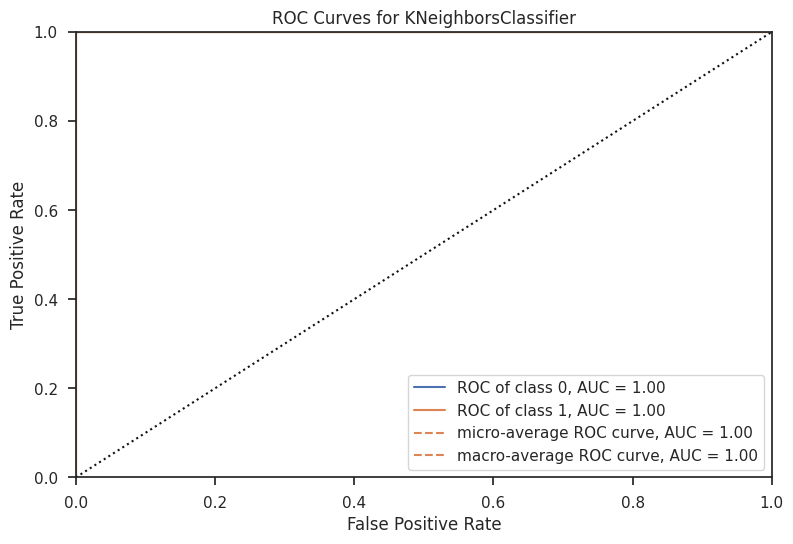

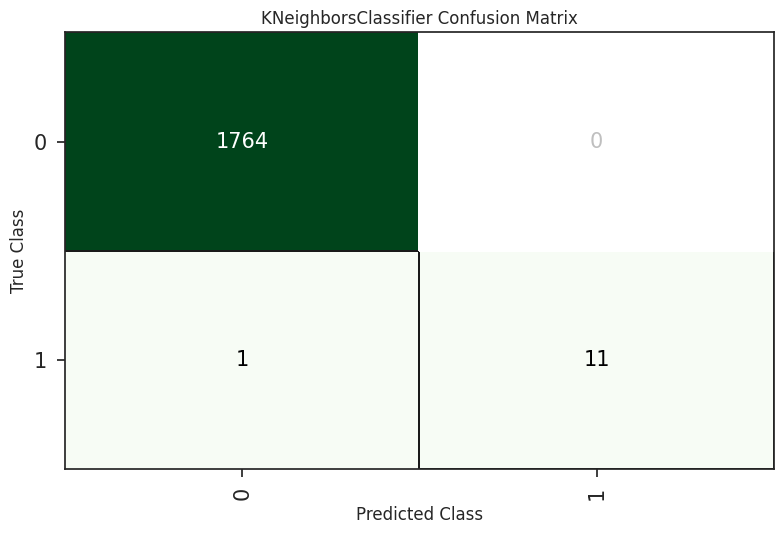

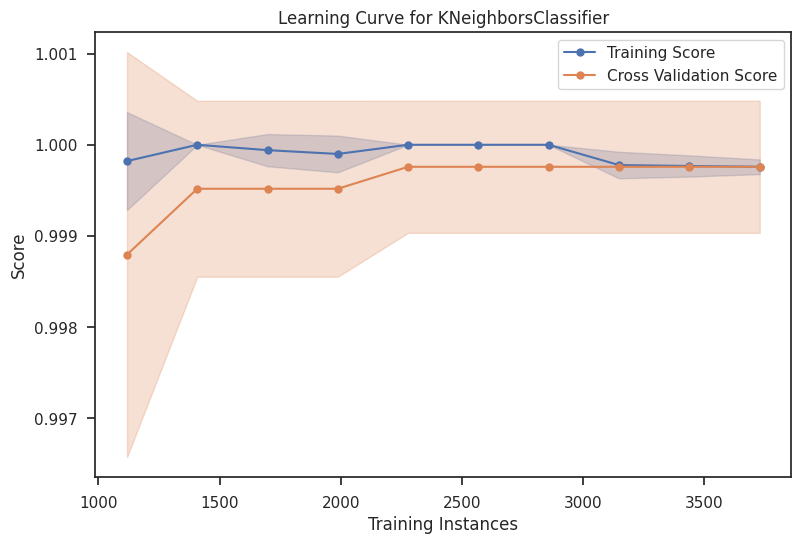

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…


Resultados de Cross Validation:
             Name    Display Name  \
ID                                  
acc         Accuracy   Accuracy     
auc              AUC        AUC     
recall        Recall     Recall     
precision  Precision      Prec.     
f1                F1         F1     
kappa          Kappa      Kappa     
mcc              MCC        MCC     

                                          Score Function                                  \
ID                                                                                         
acc                                          <function accuracy_score at 0x7afd28a07c70>   
auc        <pycaret.internal.metrics.BinaryMulticlassScoreFunc object at 0x7afd1954d300>   
recall     <pycaret.internal.metrics.BinaryMulticlassScoreFunc object at 0x7afd1954d450>   
precision  <pycaret.internal.metrics.BinaryMulticlassScoreFunc object at 0x7afd1954d6f0>   
f1         <pycaret.internal.metrics.BinaryMulticlassScoreFunc object at 0x7afd19

In [47]:
metricas = pull()
print("\nMétricas del mejor modelo:")
print(metricas)
plot_model(best_model, plot='auc')
plot_model(best_model, plot='confusion_matrix')
plot_model(best_model, plot='learning')
evaluate_model(best_model)
cv_scores = get_metrics()
print("\nResultados de Cross Validation:")
print(cv_scores)

In [51]:
def generate_knn_report(model, X_train, X_test, y_train, y_test, pycaret_model):
    y_pred = model.predict(X_test)

    def plot_to_base64(fig):
        buf = BytesIO()
        fig.savefig(buf, format='png', bbox_inches='tight')
        buf.seek(0)
        return base64.b64encode(buf.getvalue()).decode('utf-8')

    def save_pycaret_plot(pycaret_model, plot_type):
        plot_model(pycaret_model, plot=plot_type, save=True)
        latest_file = max([f for f in os.listdir() if f.endswith(".png")], key=os.path.getctime)
        with open(latest_file, "rb") as f:
            img_base64 = base64.b64encode(f.read()).decode("utf-8")
        os.remove(latest_file)
        return img_base64
    plots = []

    plt.figure(figsize=(8,6))
    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
    plt.title('Matriz de Confusión (Seaborn)')
    plots.append(plot_to_base64(plt.gcf()))
    plt.close()
    plots.append(save_pycaret_plot(pycaret_model, plot_type='confusion_matrix'))
    plots.append(save_pycaret_plot(pycaret_model, plot_type='learning'))
    plots.append(save_pycaret_plot(pycaret_model, plot_type='auc'))
    plots.append(save_pycaret_plot(pycaret_model, plot_type='gain'))
    plots.append(save_pycaret_plot(pycaret_model, plot_type='lift'))
    plots.append(save_pycaret_plot(pycaret_model, plot_type='ks'))
    plots.append(save_pycaret_plot(pycaret_model, plot_type='class_report'))
    plots.append(save_pycaret_plot(pycaret_model, plot_type='vc'))
    plots.append(save_pycaret_plot(pycaret_model, plot_type='boundary'))
    plots.append(save_pycaret_plot(pycaret_model, plot_type='threshold'))
    template = """
    <!DOCTYPE html>
    <html>
    <head>
        <title>Report KNN Classifier</title>
        <style>
            body {
                font-family: Arial, sans-serif;
                margin: 20px;
                background-color: #f5f5f5;
            }
            .container {
                max-width: 1200px;
                margin: auto;
                background-color: white;
                padding: 20px;
                border-radius: 10px;
                box-shadow: 0 0 10px rgba(0,0,0,0.1);
            }
            .metric-card {
                border: 1px solid #ddd;
                padding: 20px;
                margin: 15px 0;
                border-radius: 8px;
                background-color: white;
            }
            .metric-card h2 {
                color: #2c3e50;
                border-bottom: 2px solid #3498db;
                padding-bottom: 10px;
            }
            img {
                max-width: 100%;
                margin: 20px 0;
                border-radius: 5px;
                box-shadow: 0 0 5px rgba(0,0,0,0.1);
            }
            pre {
                background-color: #f8f9fa;
                padding: 15px;
                border-radius: 5px;
                overflow-x: auto;
            }
        </style>
    </head>
    <body>
        <div class="container">
            <h1 style="color: #2c3e50; text-align: center;">Report of the KNN Classifier model designed for the detection of seismic signals on Mars</h1>

            <div class="metric-card">
                <h2>Performance Metrics</h2>
                <pre>{{ classification_report }}</pre>
            </div>

            <div class="metric-card">
                <h2>Model graphs</h2>
                {% for plot in plots %}
                    <img src="data:image/png;base64,{{ plot }}"/>
                {% endfor %}
            </div>

            <div class="metric-card">
                <h2>Model parameters</h2>
                <pre>{{ model_params }}</pre>
            </div>
        </div>
    </body>
    </html>
    """
    t = Template(template)
    html = t.render(
        classification_report=classification_report(y_test, y_pred),
        plots=plots,
        model_params=str(model.get_params())
    )
    with open('knn_report.html', 'w') as f:
        f.write(html)
    return 'knn_report.html'

X_train, X_test, y_train, y_test = train_test_split(X[variables], X[variable], test_size=0.2, random_state=42)
report_file = generate_knn_report(best_model, X_train, X_test, y_train, y_test, pycaret_model=best_model)


Optimizar el modelo

In [53]:

tuned_model = tune_model(best_model, n_iter=50, optimize='Accuracy')
bagged_model = ensemble_model(best_model, method='Bagging', n_estimators=10)
blender = blend_models([best_model, tuned_model, bagged_model])
metrics_comparison = []
for name, model in [
    ('Original', best_model),
    ('Tuned', tuned_model),
    ('Bagged', bagged_model),
    ('Blender', blender)
]:
    predictions = predict_model(model)
    metrics = pull()
    metrics['Modelo'] = name
    predictions_time = predict_model(model, verbose=False)
    metrics['Tiempo_Prediccion'] = predictions_time.shape[0]
    metrics_comparison.append(metrics)

comparison_df = pd.concat(metrics_comparison, ignore_index=True)
print("\nComparación detallada de modelos:")
print(comparison_df)

if all(comparison_df['Accuracy'] == 1.0):
    print("\nTodos los modelos tienen rendimiento perfecto.")
    print("Seleccionando el modelo original por simplicidad.")
    best_model_name = 'Original'
    best_optimized_model = best_model
else:
    best_accuracy_idx = comparison_df['Accuracy'].idxmax()
    best_model_name = comparison_df.loc[best_accuracy_idx, 'Modelo']
    best_optimized_model = {
        'Original': best_model,
        'Tuned': tuned_model,
        'Bagged': bagged_model,
        'Blender': blender
    }[best_model_name]
print("\nAnálisis detallado del modelo seleccionado:")
predictions = predict_model(best_optimized_model)
print("\nPrimeras predicciones:")
print(predictions.head())

save_model(best_optimized_model, 'modelo_seleccionado')
from sklearn.model_selection import KFold
kf = KFold(n_splits=5, shuffle=True, random_state=42)

robustness_scores = []
for train_idx, test_idx in kf.split(X):
    X_subset = X.iloc[test_idx]
    predictions = predict_model(best_optimized_model, data=X_subset)
    robustness_scores.append(pull()['Accuracy'])

print("\nEstabilidad del modelo:")
print(f"Media de Accuracy en diferentes subconjuntos: {np.mean(robustness_scores):.4f}")
print(f"Desviación estándar: {np.std(robustness_scores):.4f}")



,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
1,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
2,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
3,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
4,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
5,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
6,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
7,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
8,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 50 candidates, totalling 500 fits


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
1,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
2,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
3,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
4,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
5,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
6,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
7,0.9976,1.0000,0.6667,1.0000,0.8000,0.7988,0.8155
8,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000


Processing:   0%|          | 0/6 [00:00<?, ?it/s]

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
1,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
2,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
3,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
4,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
5,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
6,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
7,0.9976,1.0000,0.6667,1.0000,0.8000,0.7988,0.8155
8,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000


Processing:   0%|          | 0/6 [00:00<?, ?it/s]

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,K Neighbors Classifier,0.9994,1.0000,0.9167,1.0000,0.9565,0.9562,0.9572


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,K Neighbors Classifier,0.9994,1.0000,0.9167,1.0000,0.9565,0.9562,0.9572


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,K Neighbors Classifier,0.9994,1.0000,0.9167,1.0000,0.9565,0.9562,0.9572


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Voting Classifier,0.9994,1.0000,0.9167,1.0000,0.9565,0.9562,0.9572



Comparación detallada de modelos:
           Model           Accuracy  AUC  Recall  Prec.    F1     Kappa  \
0  K Neighbors Classifier   0.9994   1.0  0.9167   1.0   0.9565  0.9562   
1  K Neighbors Classifier   0.9994   1.0  0.9167   1.0   0.9565  0.9562   
2  K Neighbors Classifier   0.9994   1.0  0.9167   1.0   0.9565  0.9562   
3       Voting Classifier   0.9994   1.0  0.9167   1.0   0.9565  0.9562   

     MCC    Modelo   Tiempo_Prediccion  
0  0.9572  Original        1776         
1  0.9572     Tuned        1776         
2  0.9572    Bagged        1776         
3  0.9572   Blender        1776         

Análisis detallado del modelo seleccionado:


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,K Neighbors Classifier,0.9994,1.0000,0.9167,1.0000,0.9565,0.9562,0.9572



Primeras predicciones:
      velocity(m/s)      freq      dif_frecuencia  etiquetas  \
1273  1.204142e-08   7.977439e-08  -2.098002e-09       0       
1459  5.146583e-09   3.409611e-08  -6.954902e-09       0       
3287  2.138324e-09   1.416639e-08   5.421200e-10       0       
4602  2.334222e-09   1.546422e-08   9.690726e-09       0       
4130  1.479949e-09   9.804663e-09   4.372702e-09       0       

      prediction_label  prediction_score  
1273          0                1.0        
1459          0                1.0        
3287          0                1.0        
4602          0                1.0        
4130          0                1.0        
Transformation Pipeline and Model Successfully Saved


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,K Neighbors Classifier,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,K Neighbors Classifier,0.9992,1.0000,0.8889,1.0000,0.9412,0.9408,0.9424


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,K Neighbors Classifier,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,K Neighbors Classifier,0.9992,1.0000,0.8333,1.0000,0.9091,0.9087,0.9125


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,K Neighbors Classifier,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000



Estabilidad del modelo:
Media de Accuracy en diferentes subconjuntos: 0.9997
Desviación estándar: 0.0004


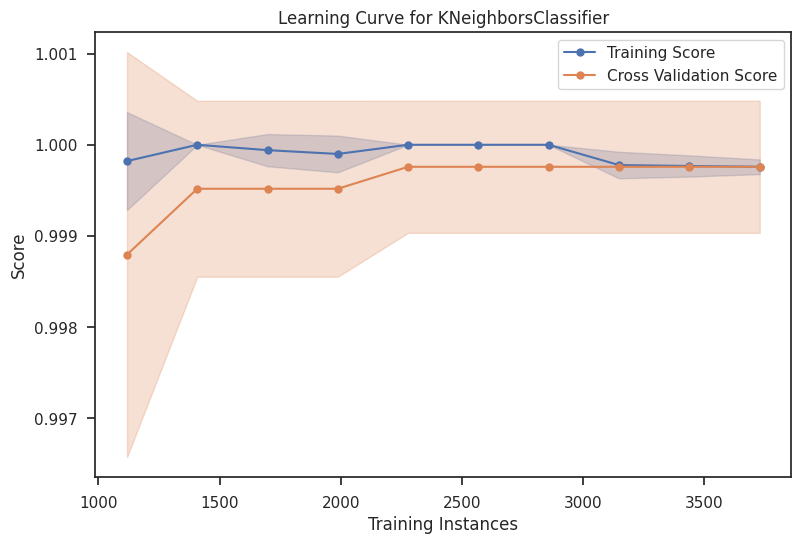

In [54]:
plot_model(best_optimized_model, plot='learning')

Testeo del modelo final

In [70]:

path='/content/space_apps_2024_seismic_detection/data/mars/training/data/XB.ELYSE.02.BHV.2022-01-02HR04_evid0006.csv'
test,finaldata=DataTest(path,True)
test=pd.concat([test])
print(test)

                 fecha             time_rel(sec)  velocity(m/s)  \
0      2022-01-02T04:00:00.025000        0.00       0.000000      
1      2022-01-02T04:00:00.075000        0.05       0.000005      
2      2022-01-02T04:00:00.125000        0.10       0.000036      
3      2022-01-02T04:00:00.175000        0.15       0.000102      
4      2022-01-02T04:00:00.225000        0.20       0.000282      
...                           ...            ...            ...   
71995  2022-01-02T04:59:59.775000     3599.75       0.000107      
71996  2022-01-02T04:59:59.825000     3599.80       0.000062      
71997  2022-01-02T04:59:59.875000     3599.85       0.000020      
71998  2022-01-02T04:59:59.925000     3599.90       0.000006      
71999  2022-01-02T04:59:59.975000     3599.95       0.000000      

       dif_velocidad  acceleration    freq    dif_frecuencia  
0        0.000000            NaN    0.000000     0.000000     
1        0.000005       0.000101    0.000101     0.000101     
2     

In [71]:
predice=best_model.predict(test[variables])


In [83]:
print(sum(predice)/len(predice),len(predice),sum(predice))
indice=np.where(predice==1)

final=pd.read_csv(path)
data=finaldata.iloc[indice[0]]

print(data)
arrival_time = data['time_rel(sec)']
print(arrival_time)


1.388888888888889e-05 72000 1
                fecha             time_rel(sec)  velocity(m/s)  dif_velocidad  \
2130  2022-01-02T04:01:46.525000      106.5        1.348703       0.370421      

      acceleration    freq    dif_frecuencia  
2130    7.408411    26.97406     7.408411     
2130    106.5
Name: time_rel(sec), dtype: float64


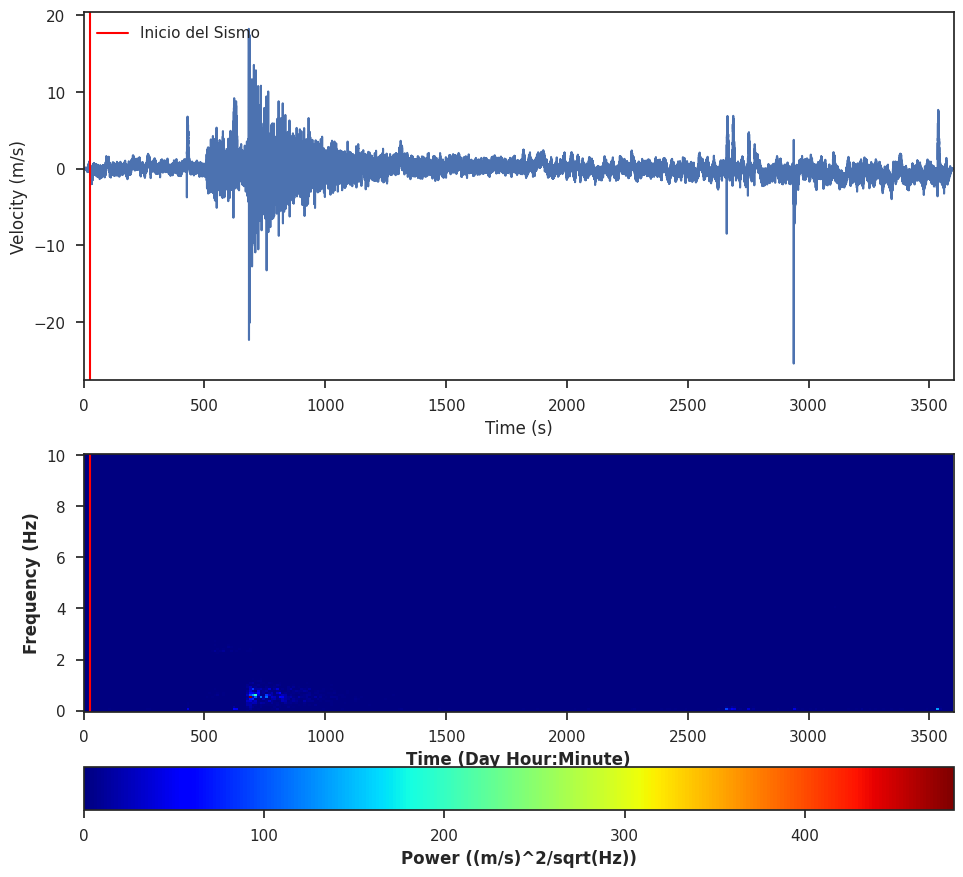

In [88]:
tr_times_filt = np.array(finaldata['time_rel(sec)'])
tr_data_filt = np.array(finaldata['velocity(m/s)'])
f, t, sxx = signal.spectrogram(tr_data_filt, fs=1.0/np.mean(np.diff(tr_times_filt)))
fig = plt.figure(figsize=(10, 10))

ax = plt.subplot(2, 1, 1)
ax.plot(tr_times_filt, tr_data_filt)
ax.axvline(x=arrival_time.iloc[0], color='red', label='Inicio del Sismo')
ax.legend(loc='upper left')
ax.set_xlim([min(tr_times_filt), max(tr_times_filt)])
ax.set_ylabel('Velocity (m/s)')
ax.set_xlabel('Time (s)')
ax2 = plt.subplot(2, 1, 2)
vals = ax2.pcolormesh(t, f, sxx, cmap=cm.jet)

# Ajustar los límites del espectrograma
ax2.set_xlim([min(tr_times_filt), max(tr_times_filt)])
ax2.set_xlabel('Time (Day Hour:Minute)', fontweight='bold')
ax2.set_ylabel('Frequency (Hz)', fontweight='bold')
ax2.axvline(x=arrival_time.iloc[0], c='red')
cbar = plt.colorbar(vals, orientation='horizontal')
cbar.set_label('Power ((m/s)^2/sqrt(Hz))', fontweight='bold')
plt.show()

Testeo 2

In [86]:
path='/content/space_apps_2024_seismic_detection/data/mars/training/data/XB.ELYSE.02.BHV.2022-02-03HR08_evid0005.csv'
test,finaldata=DataTest(path,True)
test=pd.concat([test])
predice=best_model.predict(test[variables])
indice=np.where(predice==1)
final=pd.read_csv(path)
data=finaldata.iloc[indice[0]]

print(data)
arrival_time = data['time_rel(sec)']
print(arrival_time)

               fecha             time_rel(sec)  velocity(m/s)  dif_velocidad  \
507  2022-02-03T08:00:25.359000      25.35       -0.088375      -0.104126      

     acceleration    freq    dif_frecuencia  
507   -2.082517    1.767507     1.452497     
507    25.35
Name: time_rel(sec), dtype: float64


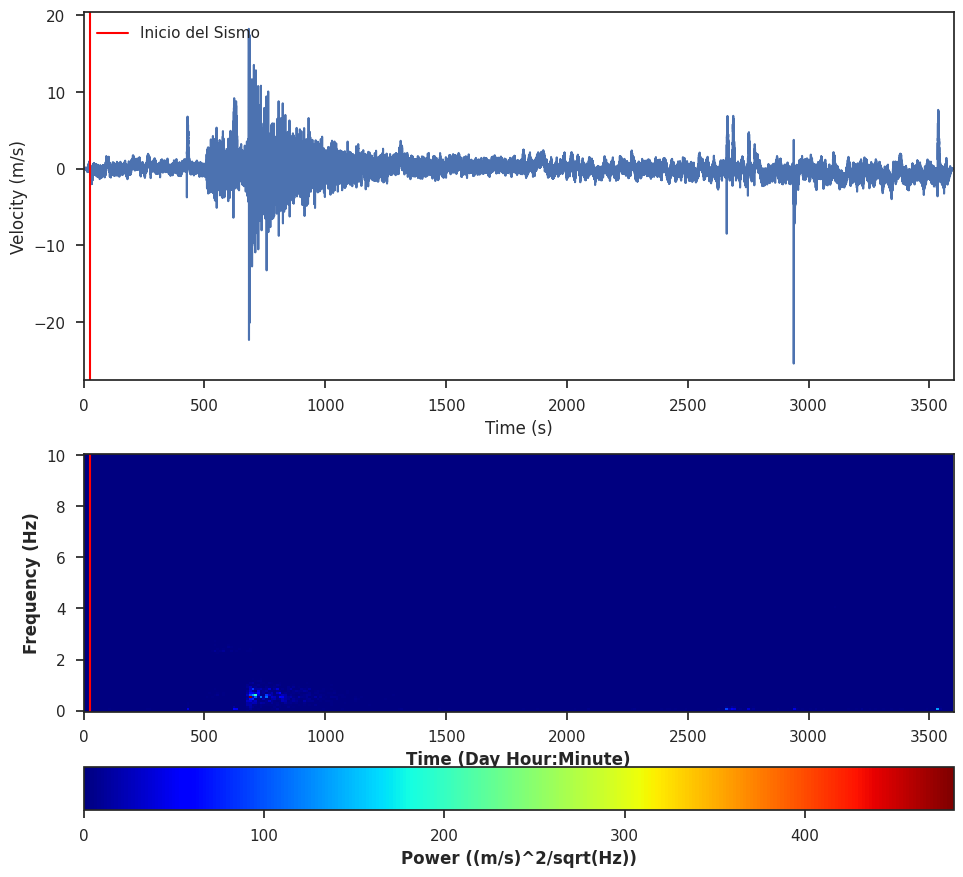

In [87]:

tr_times_filt = np.array(finaldata['time_rel(sec)'])
tr_data_filt = np.array(finaldata['velocity(m/s)'])
f, t, sxx = signal.spectrogram(tr_data_filt, fs=1.0/np.mean(np.diff(tr_times_filt)))
fig = plt.figure(figsize=(10, 10))

ax = plt.subplot(2, 1, 1)
ax.plot(tr_times_filt, tr_data_filt)
ax.axvline(x=arrival_time.iloc[0], color='red', label='Inicio del Sismo')
ax.legend(loc='upper left')
ax.set_xlim([min(tr_times_filt), max(tr_times_filt)])
ax.set_ylabel('Velocity (m/s)')
ax.set_xlabel('Time (s)')
ax2 = plt.subplot(2, 1, 2)
vals = ax2.pcolormesh(t, f, sxx, cmap=cm.jet)

# Ajustar los límites del espectrograma
ax2.set_xlim([min(tr_times_filt), max(tr_times_filt)])
ax2.set_xlabel('Time (Day Hour:Minute)', fontweight='bold')
ax2.set_ylabel('Frequency (Hz)', fontweight='bold')
ax2.axvline(x=arrival_time.iloc[0], c='red')
cbar = plt.colorbar(vals, orientation='horizontal')
cbar.set_label('Power ((m/s)^2/sqrt(Hz))', fontweight='bold')
plt.show()
prediction XB.ELYSE.02.BHV.2022-02-03HR08_evid0005

Uso del modelo

In [90]:
def predecir(model,path):
  test,finaldata=DataTest(path,True)
  variables=['velocity(m/s)','freq','dif_frecuencia']
  predice=model.predict(test[variables])
  if sum(predice)>0:
    print("The data contains seismic signals")
  else:
    print("The data does not contain seismic signals.")
predecir(best_model,'/content/space_apps_2024_seismic_detection/data/mars/test/data/XB.ELYSE.02.BHV.2019-05-23HR02_evid0041.csv')

The data contains seismic signals
